In [1]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np

Welcome to JupyROOT 6.30/04


In [2]:
def lin(x, m, q):
    return m * x + q

In [4]:
#Open root file with both shapes and measurements

FILE_PATH = "../ignore/Dati/Pi_Day/Run_ch7_Data_3_14_2024_Ascii.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show() #Display contents

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
ratecount            | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [5]:
#Load data to numpy arrays

baseline = np.array(file["tree"]["base"].array())[: , 0]
charge = np.array(file["tree"]["charge"].array())[: , 0]
amp = np.array(file["tree"]["amp"].array())[: , 0]
pshape = np.array(file["tree"]["pshape"].array())
print(pshape.shape)

(5000, 1, 1024)


BASELINE EVALUATION

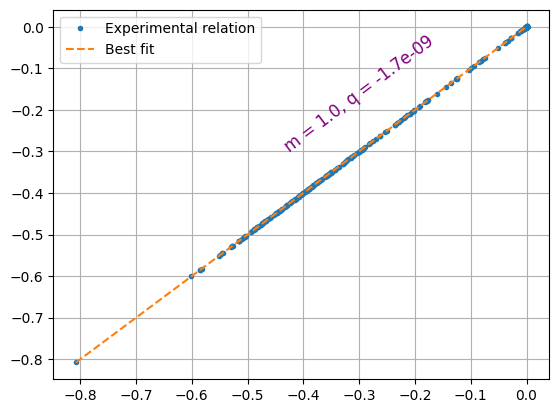

In [6]:
#Evaluate baseline: average of first 16 points   
my_baseline = np.zeros(pshape.shape[0])
for i in range(pshape.shape[0]):
    tmp_bs = np.mean(pshape[i][0][0:16])
    my_baseline[i] = np.round(tmp_bs, 6)

bsl_fit_res = scp.optimize.curve_fit(lin, baseline, my_baseline)

plt.plot(baseline, my_baseline, ls = "", marker = ".", label = "Experimental relation")
plt.plot([baseline.min(), baseline.max()], [lin(baseline.min(), bsl_fit_res[0][0], bsl_fit_res[0][1]), 
                                            lin(baseline.max(), bsl_fit_res[0][0], bsl_fit_res[0][1])],
        ls = "--", label = "Best fit")

plt.text(-0.3, -0.3, "m = " + str(round(bsl_fit_res[0][0], 2)) + ", q = " + str(round(bsl_fit_res[0][1], 10)), fontsize=12, color='purple', ha='center', 
        rotation = 37)


plt.legend()
plt.grid()

my_baseline=np.round(my_baseline, 6)

[ 168.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   86. 4585.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  157.]


Text(0.95, 0.95, 'Mean: -2.20e-09\nMedian: -4.55e-14\nStd Dev: 2.55e-07\nMin: -1.01e-06\nMax: 1.01e-06')

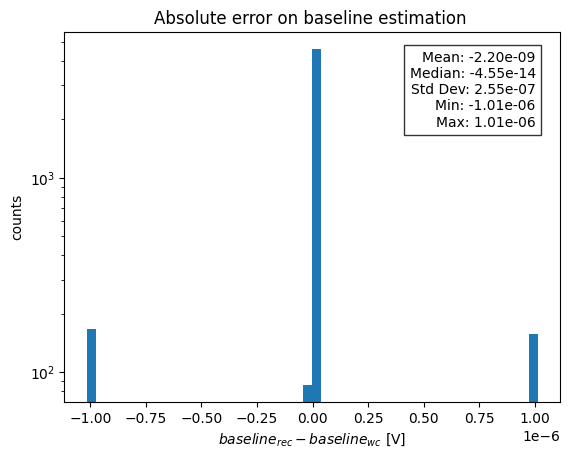

In [267]:
index=baseline!=0
data=(my_baseline[index]-baseline[index])
a=plt.hist(data, bins=50)
print(a[0])
plt.yscale("log")
plt.xlabel("$baseline_{rec}-baseline_{wc}$ [V]")
plt.ylabel("counts")
plt.title("Absolute error on baseline estimation ")
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)
min_val = np.min(data)
max_val = np.max(data)
stats_text = f'Mean: {mean:.2e}\nMedian: {median:.2e}\nStd Dev: {std_dev:.2e}\nMin: {min_val:.2e}\nMax: {max_val:.2e}'
plt.text(0.95, 0.95, stats_text, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))




CHARGE EVALUATION

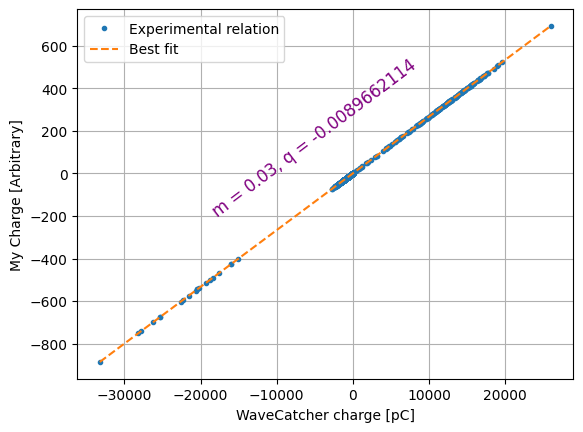

In [268]:
#Evaluate charge
my_charge = np.zeros(pshape.shape[0])

#N.B. 1 div = 1/16th of N Samples (Usually 1024)
int_start = int(pshape.shape[2] / 16 * 0.25) #Begin evaluating at 0.25 divisions (adjustable)
int_range = int(pshape.shape[2] / 16 * 15.50) #Keep evaluating for 15.50 divisions (adjustable)

X = np.arange(int_range)

for i in range(pshape.shape[0]):
    tmp_ch = trapezoid(pshape[i][0][(int_start):(int_start + int_range)] - my_baseline[i], X)
    my_charge[i] = np.round(tmp_ch,6)

chrg_fit_res = scp.optimize.curve_fit(lin, charge, my_charge)


plt.plot(charge, my_charge, ls = "", marker = ".", label = "Experimental relation")

plt.plot([charge.min(), charge.max()], [lin(charge.min(), chrg_fit_res[0][0], chrg_fit_res[0][1]), 
                                            lin(charge.max(), chrg_fit_res[0][0], chrg_fit_res[0][1])],
        ls = "--", label = "Best fit")


plt.text(-5000, -200, "m = " + str(round(chrg_fit_res[0][0], 2)) + ", q = " + str(round(chrg_fit_res[0][1], 10)), fontsize=12, color='purple', ha='center', 
        rotation = 37)

plt.xlabel("WaveCatcher charge [pC]")
plt.ylabel("My Charge [Arbitrary]")
plt.grid()
plt.legend()

my_charge=np.round(my_charge/chrg_fit_res[0][0], 6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


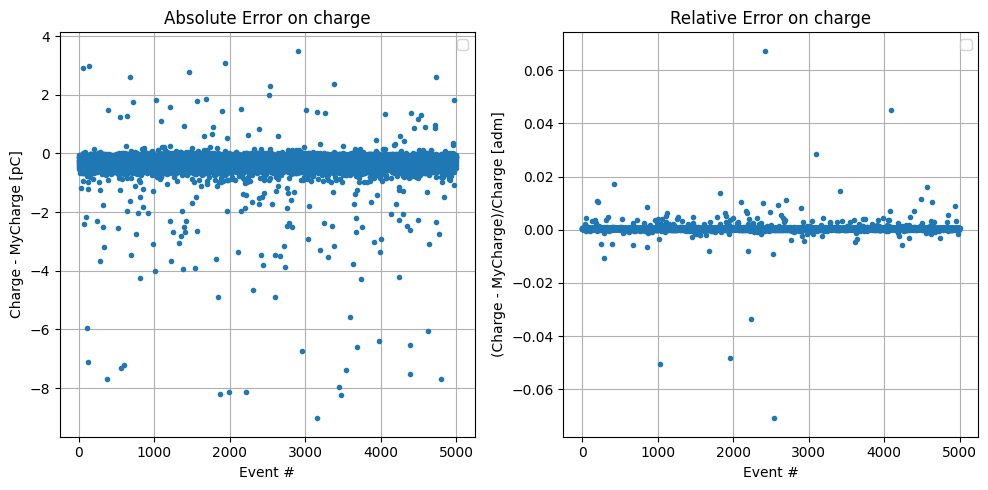

In [269]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot data on the first subplot
#axs[0].plot(my_charge - lin(charge, chrg_fit_res[0][0], chrg_fit_res[0][1]), ls = "", marker = ".")
axs[0].plot(my_charge- charge, ls = "", marker = ".")
axs[0].set_title("Absolute Error on charge")
axs[0].set_xlabel("Event #")
axs[0].set_ylabel('Charge - MyCharge [pC]')
axs[0].legend()
axs[0].grid()

# Plot data on the second subplot
axs[1].plot((my_charge - charge) / charge, ls = "", marker = ".")
axs[1].set_title("Relative Error on charge")
axs[1].set_xlabel("Event #")
axs[1].set_ylabel('(Charge - MyCharge)/Charge [adm]')
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

[1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 3.000e+00
 6.000e+00 1.200e+01 3.699e+03 1.203e+03 4.300e+01 1.000e+01 4.000e+00
 7.000e+00 1.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00]


Text(0.95, 0.95, 'Mean: 4.81e-04\nMedian: 4.63e-04\nStd Dev: 2.11e-03\nMin: -7.09e-02\nMax: 6.73e-02')

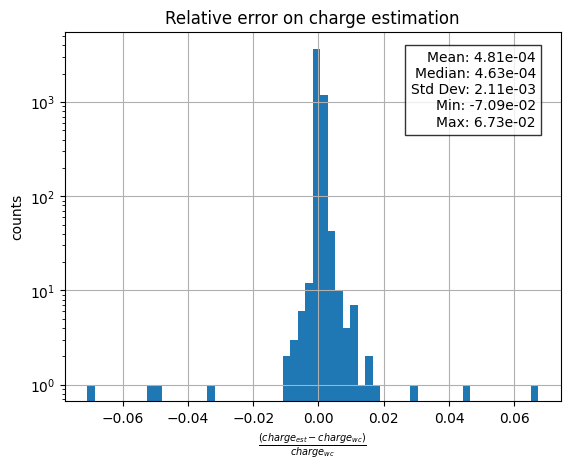

In [270]:
norm_residue = (my_charge - charge) / charge
data=norm_residue
a = plt.hist(data, bins = 60, range = (norm_residue.min(), norm_residue.max()))
print(a[0])
plt.semilogy()
plt.grid()
plt.xlabel("$\\frac{(charge_{est}-charge_{wc})}{charge_{wc}}}$")
plt.ylabel("counts")
plt.title("Relative error on charge estimation")
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)
min_val = np.min(data)
max_val = np.max(data)
stats_text = f'Mean: {mean:.2e}\nMedian: {median:.2e}\nStd Dev: {std_dev:.2e}\nMin: {min_val:.2e}\nMax: {max_val:.2e}'
plt.text(0.95, 0.95, stats_text, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))



AMPLITUDE EVALUATION
 
 #1st method: Compute the maximal distance from the baseline, regardless of the sign. Works well with both well triggered and bad triggered signals. Produces an asymmetric distribution which presumably underlies some sistematic error: reconstructed amplitudes are always less than wc's ones in absolute value 
 
 Even if this seems to me the correct algorithm I try with something else. In order to do so I limit myself to well triggered, not saturated and non noisy signals. 
 
 #2nd method: Compute minimum-maximum. This makes the distribution symmetric but at the price of increasing std of the histogram. Let me know what you prefer. 

 OBS: WC sometimes returns values which are bigger than max-min for the amplitudes and I don't know how can it do so. The 2nd method is a false regularization of ther histogram. I introduced some error on the well estimated amplitudes by referring them to the maximum instead of the baseline and this makes the sistematically bad estimated ones fit into statistical fluctuations.

2304


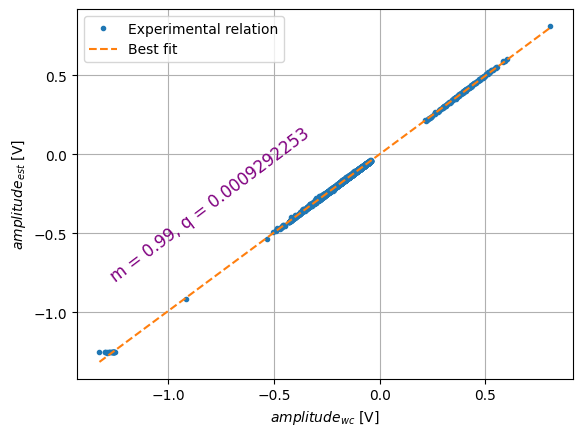

In [285]:
#1st method
my_amp = np.zeros(pshape.shape[0])
filter=[]

j = 0

for j in range(pshape.shape[0]):
        cond=np.logical_and(charge[j]<-100, baseline[i]>-0.01)
        filter.append(np.logical_and(cond, amp[j]>-1.1))
        index=np.argmax(abs(pshape[j][0]-baseline[j]))
        my_amp[j] = np.round((pshape[j][0][index]-baseline[j]), 6)
        #index=np.argmax(abs(pshape[j][0]-pshape[j][0].min()))
        #my_amp[j] = np.round((pshape[j][0].min()-baseline[j]), 6)



amp_fit_res = scp.optimize.curve_fit(lin, amp, my_amp)

plt.plot(amp, my_amp, ls = "", marker = ".", label = "Experimental relation")
plt.plot([amp.min(), amp.max()], [lin(amp.min(), amp_fit_res[0][0], amp_fit_res[0][1]), 
                                            lin(amp.max(), amp_fit_res[0][0], amp_fit_res[0][1])],
        ls = "--", label = "Best fit")
plt.xlabel("$amplitude_{wc}$ [V]")
plt.ylabel("$amplitude_{est}$ [V]")
plt.text(-0.8, -0.8, "m = " + str(round(amp_fit_res[0][0], 2)) + ", q = " + str(round(amp_fit_res[0][1], 10)), fontsize=12, color='purple', ha='center', 
        rotation = 37)


plt.legend()
plt.grid()

print(np.argmax(amp))


[1.000e+00 0.000e+00 2.000e+00 1.000e+00 0.000e+00 4.000e+00 1.000e+00
 4.000e+00 3.000e+00 4.000e+00 5.000e+00 4.000e+00 0.000e+00 8.000e+00
 7.000e+00 1.300e+01 1.000e+01 1.600e+01 1.300e+01 1.700e+01 2.500e+01
 2.900e+01 3.300e+01 4.100e+01 4.200e+01 4.000e+01 5.100e+01 6.100e+01
 7.400e+01 7.200e+01 8.800e+01 9.300e+01 8.900e+01 1.130e+02 1.360e+02
 1.400e+02 1.340e+02 1.810e+02 1.740e+02 2.280e+02 2.900e+02 3.850e+02
 5.920e+02 1.087e+03 1.750e+02 2.000e+00 1.000e+00 1.000e+00 2.000e+00
 1.000e+00]
[  12   62   86   87   88  244  276  376  526  569  620  667  771  827
  879  917 1084 1118 1215 1392 1407 1441 1459 1461 1540 1653 1661 1789
 1806 1825 2055 2098 2128 2143 2198 2231 2247 2515 2613 2656 2899 2929
 2957 2960 2984 3041 3252 3403 3469 3653 3700 3825 3831 3836 3914 4184
 4373 4389]


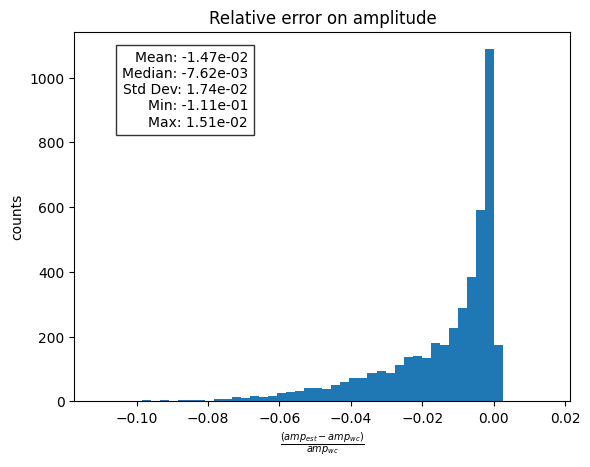

In [287]:
data=(np.round(my_amp[filter], 6)-amp[filter])/amp[filter]
plt.title("Relative error on amplitude")
plt.xlabel("$\\frac{(amp_{est}-amp_{wc})}{amp_{wc}}}$")
plt.ylabel("counts")
a=plt.hist(data, bins=50)
print(a[0])
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)
min_val = np.min(data)
max_val = np.max(data)
stats_text = f'Mean: {mean:.2e}\nMedian: {median:.2e}\nStd Dev: {std_dev:.2e}\nMin: {min_val:.2e}\nMax: {max_val:.2e}'
plt.text(0.35, 0.95, stats_text, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
print(np.where(data<-0.07)[0])


2304


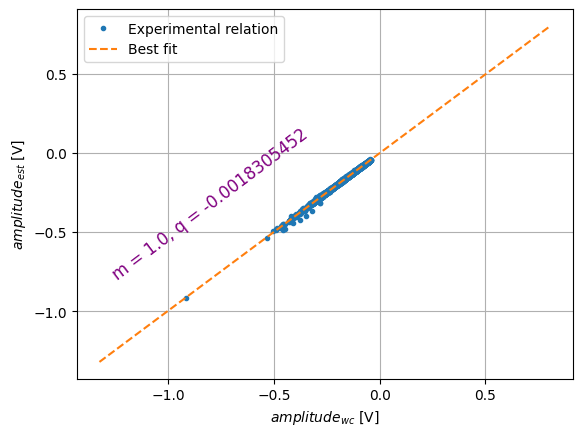

In [288]:
#2nd method
my_amp = np.zeros(pshape.shape[0])
filter=[]

j = 0

for j in range(pshape.shape[0]):
        cond=np.logical_and(charge[j]<-100, baseline[i]>-0.01)
        filter.append(np.logical_and(cond, amp[j]>-1.1))
        #index=np.argmax(abs(pshape[j][0]-baseline[j]))
        #my_amp[j] = np.round((pshape[j][0][index]-baseline[j]), 6)
        index=np.argmax(abs(pshape[j][0]-pshape[j][0].max()))
        my_amp[j] = np.round((pshape[j][0][index]-pshape[j][0].max()), 6)



amp_fit_res = scp.optimize.curve_fit(lin, amp[filter], my_amp[filter])

plt.plot(amp[filter], my_amp[filter], ls = "", marker = ".", label = "Experimental relation")
plt.plot([amp.min(), amp.max()], [lin(amp.min(), amp_fit_res[0][0], amp_fit_res[0][1]), 
                                            lin(amp.max(), amp_fit_res[0][0], amp_fit_res[0][1])],
        ls = "--", label = "Best fit")
plt.xlabel("$amplitude_{wc}$ [V]")
plt.ylabel("$amplitude_{est}$ [V]")
plt.text(-0.8, -0.8, "m = " + str(round(amp_fit_res[0][0], 2)) + ", q = " + str(round(amp_fit_res[0][1], 10)), fontsize=12, color='purple', ha='center', 
        rotation = 37)


plt.legend()
plt.grid()

print(np.argmax(amp))


[2198]


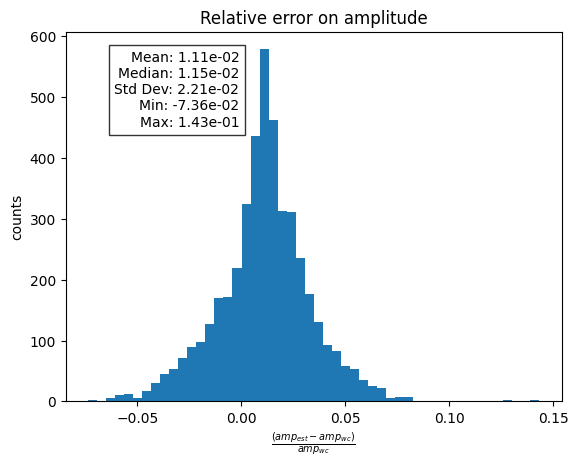

In [289]:
data=(np.round(my_amp[filter], 6)-amp[filter])/amp[filter]
plt.title("Relative error on amplitude")
plt.xlabel("$\\frac{(amp_{est}-amp_{wc})}{amp_{wc}}}$")
plt.ylabel("counts")
a=plt.hist(data, bins=50)
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)
min_val = np.min(data)
max_val = np.max(data)
stats_text = f'Mean: {mean:.2e}\nMedian: {median:.2e}\nStd Dev: {std_dev:.2e}\nMin: {min_val:.2e}\nMax: {max_val:.2e}'
plt.text(0.35, 0.95, stats_text, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
print(np.where(data<-0.07)[0])

In [ ]:
i=260
plt.plot(pshape[i][0])
print(pshape.shape)
print(baseline[i], my_baseline[i])
print(amp[i], my_amp[i])
index=np.argmax(abs(pshape[i][0]-pshape[i][0].max()))
print(index)
print(pshape[i][0][index])
print(np.round((pshape[i][0][index]-pshape[i][0].max()), 6))


In [82]:
def pulse_shape(t, A, t1, t2, t01, t02, base):
    tmp = A * (np.exp(-(t-t01)/t1) - np.exp(-(t-t02)/t2)) + base

    for i in range(len(tmp)):
        if tmp[i] > 0:
            tmp[i] = base
    
    return tmp

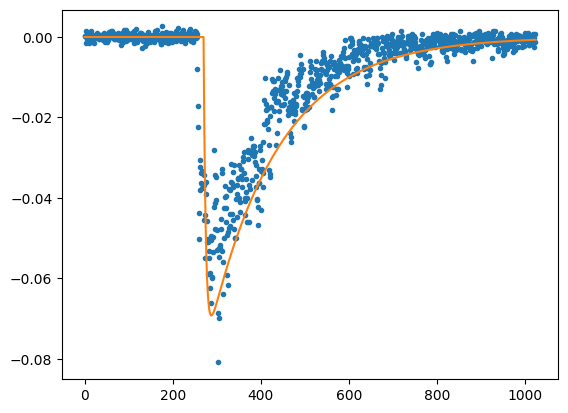

In [122]:

rng = np.arange(0, 1024)

shape_fit_res = scp.optimize.curve_fit(pulse_shape, pshape[0, 0, :], rng, p0 = (-0.08, 380, 5, 270, 270, 0), bounds = ([-1, 0, 0, 0, 0, -0.01], [0, 1000, 1000, 400, 400, 0.0]),
                                       full_output = True, gtol = 1e-15, ftol = 1e-15, xtol = 5e-16)
plt.plot(rng, pshape[0, 0, 0:], ls = "", marker = ".")
plt.plot(np.arange(0, 1024, 0.1), pulse_shape(np.arange(0, 1024, 0.1), shape_fit_res[0][0], shape_fit_res[0][1], shape_fit_res[0][2], 
                                                                       shape_fit_res[0][3], shape_fit_res[0][4], shape_fit_res[0][5]))
#plt.plot(np.arange(0, 1024, 0.1), pulse_shape(np.arange(0, 1024, 0.1), -0.008, 0.15, 0.075, 0.079, 0.4))